In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pandas as pd

import copulagp.marginal as mg
from copulagp import bvcopula
import torch
from scipy import interpolate

LENGTH = 200 #cm long VR corridor

def cond_interp(cond_u,u,rate,pos,bins=100,av=6):  
    '''
    Interpolates the inverse CCDF
    cond_u: conditioned variable from [0,1]
    u: a variable prior to conditioning [0,1]
    rate: a firing rate that corresponds to u
    pos: conditioning variable
    bins: number of bins
    av: number of neighbouring bins that are included
        in ccdf estimation (rule of thumb:
        make higher untill fix messages disappear)
    '''
    cond_y = np.empty_like(cond_u)
    for i in range(bins):
        mask_av = (pos>=(i-av)/bins) & (pos<=(i+av+1)/bins)
        mask = (pos>=i/bins) & (pos<=(i+1)/bins)
        if cond_u[mask].min()<u[mask_av].min():
            print('Fixing min')
            cond_u[mask & (cond_u<u[mask_av].min())] = u[mask_av].min()
        if cond_u[mask].max()>u[mask_av].max():
            print('Fixing max')
            cond_u[mask & (cond_u>u[mask_av].max())] = u[mask_av].max()
        interp = interpolate.interp1d(u[mask_av],rate[mask_av],
                                    kind='slinear')
        cond_y[mask] = interp(cond_u[mask])
        if np.any(cond_y==np.inf):
            print(cond_u[cond_y==np.inf],pos[cond_y==np.inf],u[mask].min(),rate[mask].min(),u[mask].max(),rate[mask].max())
    cond_y[rate<0.01] = rate[rate<0.01] # remove transformed jitter
    assert np.all(cond_y==cond_y)
    assert np.all(cond_y!=np.inf), cond_u[cond_y==np.inf]
    return cond_y

In [2]:
session = 'M7_D21_2020-11-26_16-09-48'
data = pd.read_pickle(f'{session}_u.pkl')
data.iloc[2]

session_id                                   M7_D21_2020-11-26_16-09-48
cluster_id                                                            9
mean_firing_rate                                              35.845934
brain_region                                                      [MEC]
max_trial_number                                                    487
firing_times          [671.0, 2864.0, 3116.0, 5685.0, 6040.0, 6794.0...
x_position_cm         [95.875, 96.9375, 96.75, 99.375, 99.375, 101.5...
trial_number          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
trial_type            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
spike_rate_in_time    [[21.79213012464343, 29.838882078138344, 38.37...
rewarded_trials       [1, 5, 9, 13, 17, 21, 25, 29, 37, 41, 45, 49, ...
rewarded_locations    [94.5, 95.5, 94.5, 91.5, 95.5, 89.5, 91.5, 104...
u_vel_t0              [0.15554627862156586, 0.9605574569584459, 0.49...
u_rate_t0             [0.23423157354671148, 0.7382157290778821, 

In [45]:
session_id=2
u_vel_t0=data.iloc[session_id].u_vel_t0
u_rate_t0=data.iloc[session_id].u_rate_t0
u_vel_t1=data.iloc[session_id].u_vel_t1
u_rate_t1=data.iloc[session_id].u_rate_t1
[ds_rate, ds_vel, ds_pos, _, trial_type] = data.iloc[session_id].spike_rate_in_time
pos_t0 = ds_pos[trial_type==0]/LENGTH
pos_t1 = ds_pos[trial_type==1]/LENGTH
ds_rate_t0 = ds_rate[trial_type==0]
ds_rate_t1 = ds_rate[trial_type==1]

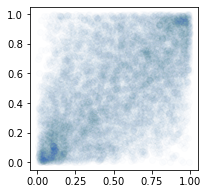

In [46]:
plt.figure(figsize=(3,3))
plt.scatter(u_vel_t1,u_rate_t1,alpha=0.01)

# Gauss

In [47]:
device='cuda:0'
train_x = torch.tensor(pos_t1).float().to(device=device)
train_y = torch.tensor([u_rate_t1,u_vel_t1]).t().float().to(device=device)

likelihoods = [bvcopula.GaussianCopula_Likelihood()]
%time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,device=device, prior_rbf_length=2.0)
print(f"WAIC: {waic}")

CPU times: user 7.99 s, sys: 19.7 ms, total: 8.01 s
Wall time: 8 s
WAIC: -0.1523744761943817


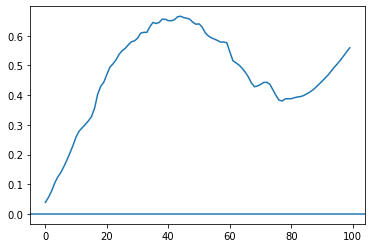

In [48]:
test_x = torch.linspace(0,1,100).float().to(device=device)
theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()
plt.plot(theta)
plt.axhline(0)

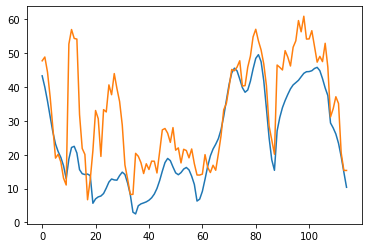

In [49]:
model.gp_model.eval()
# copula = model.marginalize(train_x) # marginalize the GP
with torch.no_grad():
    f = model.gp_model(train_x).mean
copula = model.likelihood.get_copula(f) 
cond_u = copula.ccdf(train_y).cpu().numpy()
cond_y = cond_interp(cond_u,u_rate_t1,ds_rate_t1,pos_t1,bins=10)

plt.plot(ds_rate_t1[10000:11000])
plt.plot(cond_y[10000:11000])
# rate_HPC[::200,5].shape
# cond_u.shape

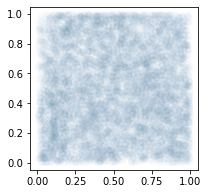

In [50]:
plt.figure(figsize=(3,3))
plt.scatter(u_vel_t1,cond_u,alpha=0.01)

/tmp/ipykernel_37020/3509440611.py:4: RuntimeWarning: Mean of empty slice.
  averages[0,i] =  ds_rate_t1[mask].mean()
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_37020/3509440611.py:5: RuntimeWarning: Mean of empty slice.
  averages[1,i] =  cond_y[mask].mean()
/home/nina/miniconda3/envs/SarahData/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


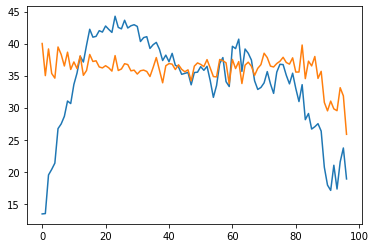

In [51]:
averages = np.empty((2,100))
for i in range(100):
    mask = (pos_t1>=i/100) & (pos_t1 <=(i+1)/100)
    averages[0,i] =  ds_rate_t1[mask].mean()
    averages[1,i] =  cond_y[mask].mean()
plt.plot(averages.T)

# Non-gauss

In [ ]:
to_recalculate = cond_V1['waics']<-0.005
np.sum(to_recalculate)